In [39]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Instrument Response Functions (IRFs) and sensitivity

**Recommended datasample(s):**
Datasets of fully-analyzed showers used to obtain Instrument Response Functions, which in the default pipeline workflow are called ``gamma3``, ``proton2`` and ``electron``.

**Data level(s):** DL3 (selected event lists of signal-like events and IRFs)

**Description:**

This notebook contains DL3 and benchmarks for the _protopipe_ pipeline. 
Latest performance results cannot be shown on this public documentation and are therefore hosted at [this RedMine page](https://forge.in2p3.fr/projects/benchmarks-reference-analysis/wiki/Protopipe_performance_data).

**Requirements and steps to reproduce:**

- get a DL3 file generated using ``protopipe-DL3-EventDisplay``,

- execute the notebook with ``protopipe-BENCHMARK``,

``protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n DL3/benchmarks_DL3_IRFs_and_sensitivity``

To obtain the list of all available parameters add ``--help-notebook``.

**Comparison with other pipelines:**

The MC production to be used and the appropriate set of files to use for this notebook can be found [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#The-MC-sample ).

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.   
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.  
Please, strip the output before pushing.

**TODO:**  
- ...

## Table of contents

* [Optimized cuts](#Optimized-cuts)
    - [Direction cut](#Direction-cut)
    - [Gamma/Hadron separation](#Gamma/Hadron-separation)
* [Differential sensitivity from cuts optimization](#Differential-sensitivity-from-cuts-optimization)
* [Sensitivity against requirements](#Sensitivity-against-requirements)
* [Sensitivity comparison between pipelines](#Sensitivity-comparison-between-pipelines)
* [IRFs](#IRFs)
    - [Effective area](#Effective-area)
    - [Point Spread Function](#Point-Spread-Function)
        + [Angular resolution](#Angular-resolution)
    - [Energy dispersion](#Energy-dispersion)
        + [Energy resolution](#Energy-resolution)
    - [Background rate](#Background-rate)

## Imports
[back to top](#Table-of-contents)

In [40]:
# From the standard library
import os
from pathlib import Path

# From pyirf
import pyirf
from pyirf.binning import bin_center
from pyirf.utils import cone_solid_angle

# From other 3rd-party libraries
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable, Table, Column
import uproot

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

## Input data
[back to top](#Table-of-contents)

In [ ]:
#Parametrized cell
analyses_directory = "" # path to the 'analyses' folder
output_directory = Path.cwd() # default output directory for plots
analysis_name = "" # Name fo the analysis
input_filename = "" # Name of the file produced with protopipe-DL3-EventDisplay
MARS_label = "CTAMARS" # Plot legend label for CTAMARS
ED_label = "EventDisplay" # Plot legend label for EventDisplay
site = 'North' # North (La Palma) or South (Paranal) (default: North)
obs_time = '50h' # Observation time (default: 50 h)

### Protopipe
[back to top](#Table-of-contents)

In [42]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

In [43]:
production = input_filename.split("protopipe_")[1].split("_Time")[0]
input_directory = Path(analyses_directory) / analysis_name / Path("data/DL3")
protopipe_file = input_directory / input_filename

### ASWG performance
[back to top](#Table-of-contents)

In [44]:
if load_CTAMARS:
    try:
        indir_CTAMARS = Path(input_directory_CTAMARS["parent_directory"]) / Path(input_directory_CTAMARS["DL3/input_directory"])
        infile_CTAMARS = Path(input_directory_CTAMARS["DL3/input_file"])
        MARS_performance = uproot.open(Path(indir_CTAMARS, infile_CTAMARS))
    except (NameError, KeyError):
        print("WARNING: CTAMARS data undefined! Please, check the documentation of protopipe-BENCHMARKS.")

In [ ]:
if load_EventDisplay:
    try:
        indir_ED = Path(EventDisplay_input_directory)
        ED_performance = uproot.open(Path(indir_ED, infile_ED))
    except (NameError, KeyError):
        print("WARNING: EventDisplay data undefined! Please, check the documentation of protopipe-BENCHMARKS.")

### Requirements
[back to top](#Table-of-contents)

In [46]:
if load_requirements:
    try:
        requirements_indir=requirements_input_directory
    except (NameError, KeyError):
        print("WARNING: Requirements data undefined! Please, check the documentation of protopipe-BENCHMARKS.")

# Full array
infiles = dict(sens=f'/{site}-{obs_time}.dat')
requirements = dict()
for key in infiles.keys():
    requirements[key] = Table.read(requirements_indir + infiles[key], format='ascii')
requirements['sens'].add_column(Column(data=(10**requirements['sens']['col1']), name='ENERGY'))
requirements['sens'].add_column(Column(data=requirements['sens']['col2'], name='SENSITIVITY'))

## Optimized cuts
[back to top](#Table-of-contents)

### Direction
[back to top](#Table-of-contents)

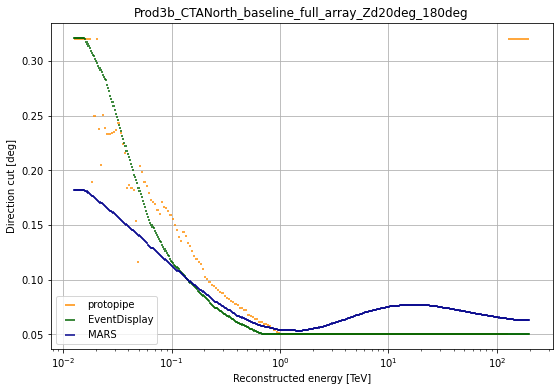

In [47]:
# protopipe
rad_max = QTable.read(protopipe_file, hdu='RAD_MAX')[0]
plt.errorbar(
    0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])[1:-1].to_value(u.TeV),
    rad_max['RAD_MAX'].T[1:-1, 0].to_value(u.deg),
    xerr=0.5 * (rad_max['ENERG_HI'] - rad_max['ENERG_LO'])[1:-1].to_value(u.TeV),
    ls='',
    label='protopipe',
    color='DarkOrange'
)

# ED
theta_cut_ed, edges = ED_performance['ThetaCut;1'].to_numpy()
plt.errorbar(
    bin_center(10**edges),
    theta_cut_ed,
    xerr=np.diff(10**edges),
    ls='',
    label='EventDisplay',
    color='DarkGreen'
)

# MARS
theta_cut_ed = np.sqrt(MARS_performance['Theta2Cut;1'].to_numpy()[0])
edges = MARS_performance['Theta2Cut;1'].to_numpy()[1]
plt.errorbar(
    bin_center(10**edges),
    theta_cut_ed,
    xerr=np.diff(10**edges),
    ls='',
    label='MARS',
    color='DarkBlue'
)

plt.legend()
plt.ylabel('Direction cut [deg]')
plt.xlabel('Reconstructed energy [TeV]')
plt.xscale('log')
plt.title(production)
plt.grid()

None # to remove clutter by mpl objects

### Gamma/Hadron separation
[back to top](#Table-of-contents)

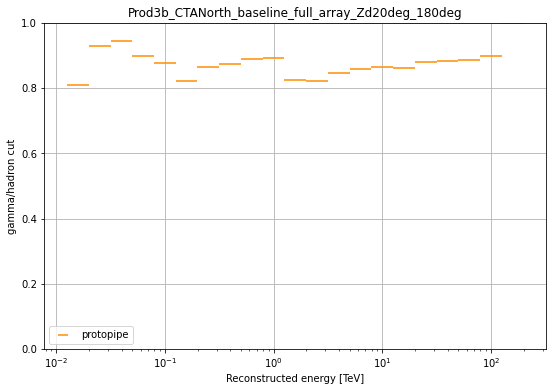

In [48]:
# protopipe
gh_cut = QTable.read(protopipe_file, hdu='GH_CUTS')[1:-1]
plt.errorbar(
    0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV),
    gh_cut['cut'],
    xerr=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV),
    ls='',
    label='protopipe',
    color='DarkOrange'
)

plt.legend()
plt.ylabel('gamma/hadron cut')
plt.xlabel('Reconstructed energy [TeV]')
plt.xscale('log')
plt.ylim(0,1)
plt.title(production)
plt.grid()

None # to remove clutter by mpl objects

## Differential sensitivity from cuts optimization
[back to top](#Table-of-contents)

In [49]:
# [1:-1] removes under/overflow bins
sensitivity_protopipe = QTable.read(protopipe_file, hdu='SENSITIVITY')[1:-1]

# make it print nice
sensitivity_protopipe['reco_energy_low'].info.format = '.3g'
sensitivity_protopipe['reco_energy_high'].info.format = '.3g'
sensitivity_protopipe['reco_energy_center'].info.format = '.3g'
sensitivity_protopipe['relative_sensitivity'].info.format = '.2g'
sensitivity_protopipe['flux_sensitivity'].info.format = '.3g'

for k in filter(lambda k: k.startswith('n_'), sensitivity_protopipe.colnames):
    sensitivity_protopipe[k].info.format = '.1f'

sensitivity_protopipe

reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_signal_weighted,n_background,n_background_weighted,significance,relative_sensitivity,flux_sensitivity
TeV,TeV,TeV,,,,,,,1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0126,0.02,0.0163,6.0,10.0,0.0,0.0,5.986250026900071,0.13,1.83e-07
0.02,0.0316,0.0258,482.9,602.3,113.9,59301.5,4.999999999998408,0.02,8.35e-09
0.0316,0.0501,0.0409,408.5,432.2,79.6,30297.6,5.000000000001376,0.016,2e-09
0.0501,0.0794,0.0648,776.8,574.1,224.2,53827.5,5.0000000000005,0.0095,3.51e-10
0.0794,0.126,0.103,1148.4,652.1,343.2,65207.7,5.162817097104527,0.0068,7.51e-11
0.126,0.2,0.163,968.3,397.2,242.1,25523.3,4.999999999999886,0.0048,1.57e-11
0.2,0.316,0.258,391.9,118.8,57.4,2128.9,5.000000000007594,0.0036,3.59e-12
0.316,0.501,0.409,292.8,66.3,33.5,610.6,5.0000000002724665,0.003,8.76e-13


## Sensitivity against requirements
[back to top](#Table-of-contents)

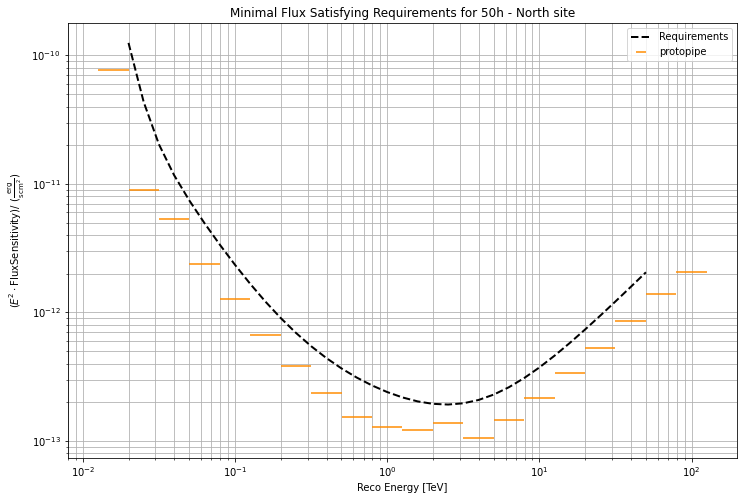

In [50]:
plt.figure(figsize=(12,8))

unit = u.Unit('erg cm-2 s-1')

# protopipe
e = sensitivity_protopipe['reco_energy_center']
w = (sensitivity_protopipe['reco_energy_high'] - sensitivity_protopipe['reco_energy_low'])
s = (e**2 * sensitivity_protopipe['flux_sensitivity'])

plt.errorbar(
    e.to_value(u.TeV),
    s.to_value(unit),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label='protopipe',
    color='DarkOrange'
)

# Add requirements
plt.plot(requirements['sens']['ENERGY'], 
         requirements['sens']['SENSITIVITY'], 
         color='black', 
         ls='--', 
         lw=2, 
         label='Requirements'
)

# Style settings
plt.title(f'Minimal Flux Satisfying Requirements for {obs_time} - {site} site')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")
plt.xlabel("Reco Energy [TeV]")

plt.grid(which="both")
plt.legend()


None # to remove clutter by mpl objects


## Sensitivity comparison between pipelines
[back to top](#Table-of-contents)

<Figure size 864x576 with 0 Axes>

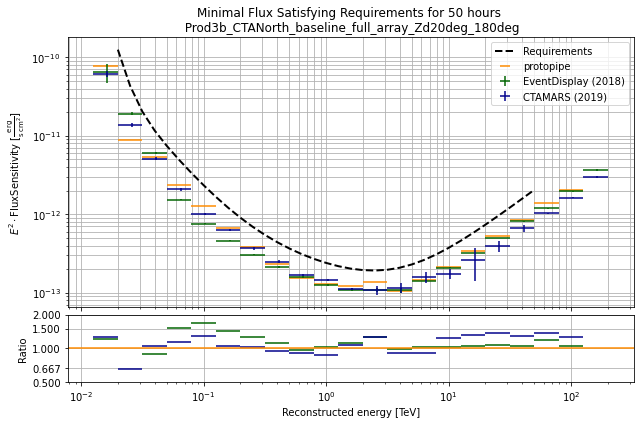

In [51]:
plt.figure(figsize=(12,8))
fig, (ax_sens, ax_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [4, 1]},
    sharex=True,
)
unit = u.Unit('erg cm-2 s-1')

# Add requirements
ax_sens.plot(requirements['sens']['ENERGY'], 
         requirements['sens']['SENSITIVITY'], 
         color='black', 
         ls='--', 
         lw=2, 
         label='Requirements'
)

# protopipe
e = sensitivity_protopipe['reco_energy_center']
w = (sensitivity_protopipe['reco_energy_high'] - sensitivity_protopipe['reco_energy_low'])
s_p = (e**2 * sensitivity_protopipe['flux_sensitivity'])
ax_sens.errorbar(
    e.to_value(u.TeV),
    s_p.to_value(unit),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label='protopipe',
    color='DarkOrange'
)

# ED
s_ED, edges = ED_performance["DiffSens"].to_numpy()
yerr = ED_performance["DiffSens"].errors()
bins = 10**edges
x = bin_center(bins)
width = np.diff(bins)
ax_sens.errorbar(
    x,
    s_ED, 
    xerr=width/2,
    yerr=yerr,
    label=ED_label,
    ls='',
    color='DarkGreen'
)

# MARS
s_MARS, edges = MARS_performance["DiffSens"].to_numpy()
yerr = MARS_performance["DiffSens"].errors()
bins = 10**edges
x = bin_center(bins)
width = np.diff(bins)
ax_sens.errorbar(
    x,
    s_MARS, 
    xerr=width/2,
    yerr=yerr,
    label=MARS_label,
    ls='',
    color='DarkBlue'
)

ax_ratio.errorbar(
    e.to_value(u.TeV), 
    s_p.to_value(unit) / s_ED,
    xerr=w.to_value(u.TeV)/2,
    ls='',
    label = "",
    color='DarkGreen'
)
ax_ratio.errorbar(
    e.to_value(u.TeV), 
    s_p.to_value(unit) / s_MARS,
    xerr=w.to_value(u.TeV)/2,
    ls='',
    label = "",
    color='DarkBlue'
)
ax_ratio.axhline(1, color = 'DarkOrange')

ax_ratio.set_yscale('log')
ax_ratio.set_xlabel("Reconstructed energy [TeV]")
ax_ratio.set_ylabel('Ratio')
ax_ratio.grid()
ax_ratio.yaxis.set_major_formatter(ScalarFormatter())

ax_ratio.set_ylim(0.5, 2.0)
ax_ratio.set_yticks([0.5, 2/3, 1, 3/2, 2])
ax_ratio.set_yticks([], minor=True)

# Style settings
ax_sens.set_title(f'Minimal Flux Satisfying Requirements for 50 hours \n {production}')
ax_sens.set_xscale("log")
ax_sens.set_yscale("log")
ax_sens.set_ylabel(rf"$E^2 \cdot \mathrm{{Flux Sensitivity}} $ [{unit.to_string('latex')}]")

ax_sens.grid(which="both")
ax_sens.legend()
fig.tight_layout(h_pad=0)


None # to remove clutter by mpl objects

## IRFs
[back to top](#Table-of-contents)

### Effective area
[back to top](#Table-of-contents)

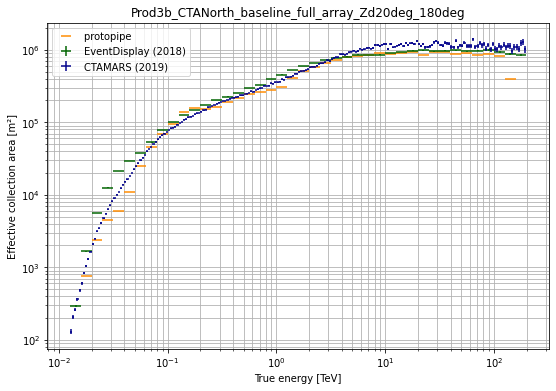

In [53]:
# protopipe
# uncomment the other strings to see effective areas
# for the different cut levels. Left out here for better
# visibility of the final effective areas.
suffix =''
#'_NO_CUTS'
#'_ONLY_GH'
#'_ONLY_THETA'

area = QTable.read(protopipe_file, hdu='EFFECTIVE AREA' + suffix)[0]
plt.errorbar(
    0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
    area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
    xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
    ls='',
    label='protopipe ' + suffix,
    color='DarkOrange'
)
    
# ED
y, edges = ED_performance["EffectiveAreaEtrue"].to_numpy()
yerr = ED_performance["EffectiveAreaEtrue"].errors()
x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=ED_label,
             color='DarkGreen'
            )

# MARS
y, edges = MARS_performance["EffectiveAreaEtrue"].to_numpy()
yerr = MARS_performance["EffectiveAreaEtrue"].errors()
x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=MARS_label,
             color='DarkBlue'
            )

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy [TeV]")
plt.ylabel("Effective collection area [m²]")
plt.title(production)
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

### Point Spread Function
[back to top](#Table-of-contents)

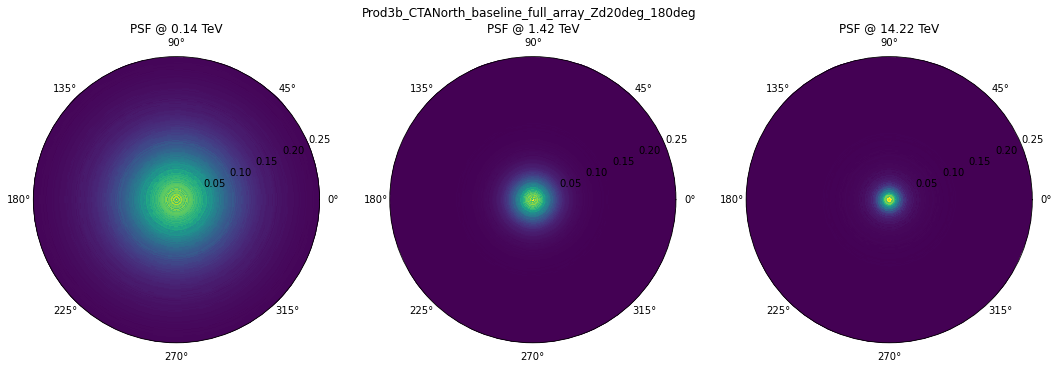

In [54]:
psf_table = QTable.read(protopipe_file, hdu='PSF')[0]
# select the only fov offset bin
psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)

offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
phi_bins = np.linspace(0, 2 * np.pi, 100)



# Let's make a nice 2d representation of the radially symmetric PSF
r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

# look at a single energy bin
# repeat values for each phi bin
center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])


fig = plt.figure(figsize=(15, 5))
plt.suptitle(production)
axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]


for bin_id, ax in zip([10, 20, 30], axs):
    image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))
    
    ax.set_title(f'PSF @ {center[bin_id]:.2f}')
    ax.pcolormesh(phi, r, image)
    ax.set_ylim(0, 0.25)
    ax.set_aspect(1)
    
fig.tight_layout()

None # to remove clutter by mpl objects


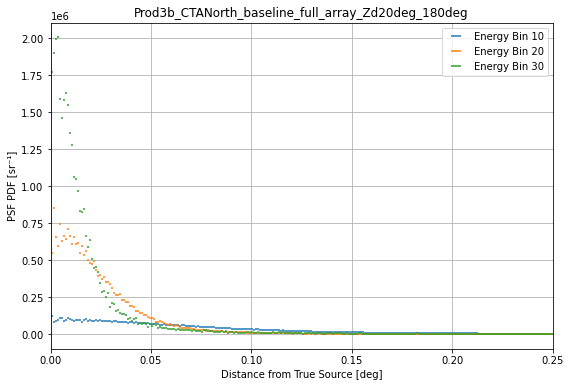

In [55]:
# Profile
center = 0.5 * (offset_bins[1:] + offset_bins[:-1])
xerr = 0.5 * (offset_bins[1:] - offset_bins[:-1])

for bin_id in [10, 20, 30]:
    plt.errorbar(
        center.to_value(u.deg),
        psf[bin_id],
        xerr=xerr.to_value(u.deg),
        ls='',
        label=f'Energy Bin {bin_id}'
    )
    
#plt.yscale('log')
plt.legend()
plt.xlim(0, 0.25)
plt.ylabel('PSF PDF [sr⁻¹]')
plt.xlabel('Distance from True Source [deg]')
plt.title(production)
plt.grid()

None # to remove clutter by mpl objects

#### Angular resolution
[back to top](#Table-of-contents)

NOTE: MARS and EventDisplay Angular Resolution are plotted as a function of Reco Energy, protopipe ones as a function of True Energy

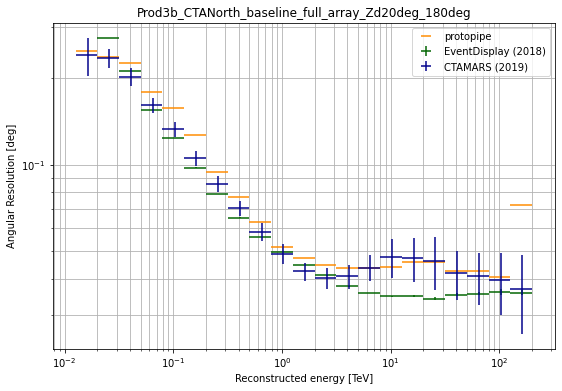

In [57]:
# protopipe
ang_res = QTable.read(protopipe_file, hdu='ANGULAR_RESOLUTION')

plt.errorbar(
    0.5 * (ang_res['reco_energy_low'] + ang_res['reco_energy_high']).to_value(u.TeV),
    ang_res['angular_resolution'].to_value(u.deg),
    xerr=0.5 * (ang_res['reco_energy_high'] - ang_res['reco_energy_low']).to_value(u.TeV),
    ls='',
    label='protopipe',
    color='DarkOrange'
)

# ED
y, edges = ED_performance["AngRes"].to_numpy()
yerr = ED_performance["AngRes"].errors()
x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=ED_label,
             color='DarkGreen')

# MARS
y, edges = MARS_performance["AngRes"].to_numpy()
yerr = MARS_performance["AngRes"].errors()
x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=MARS_label,
             color='DarkBlue')

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Angular Resolution [deg]")
plt.title(production)
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

### Energy dispersion
[back to top](#Table-of-contents)

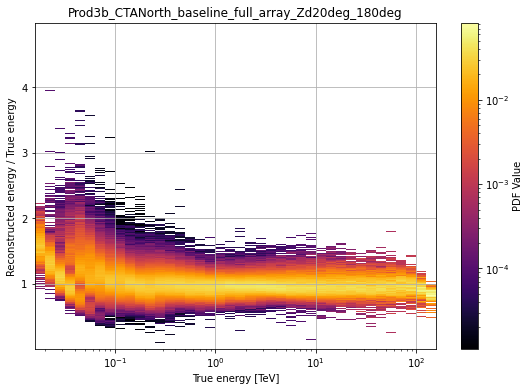

In [58]:
from matplotlib.colors import LogNorm

edisp = QTable.read(protopipe_file, hdu='ENERGY_DISPERSION')[0]

e_bins = edisp['ENERG_LO'][1:]
migra_bins = edisp['MIGRA_LO'][1:]

plt.title(production)
plt.pcolormesh(e_bins.to_value(u.TeV), 
               migra_bins, 
               edisp['MATRIX'].T[1:-1, 1:-1, 0].T,
               cmap='inferno',
               norm=LogNorm())

plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.colorbar(label='PDF Value')

plt.xlabel("True energy [TeV]")
plt.ylabel("Reconstructed energy / True energy")

None # to remove clutter by mpl objects

#### Energy resolution
[back to top](#Table-of-contents)

/var/folders/2z/142033n17rbfy969s6h4hymw0000gn/T/ipykernel_9739/1126520352.py:11: RuntimeWarning: invalid value encountered in true_divide
  ED_migra = ED_migra/np.sum(ED_migra, axis=1)[np.newaxis].T


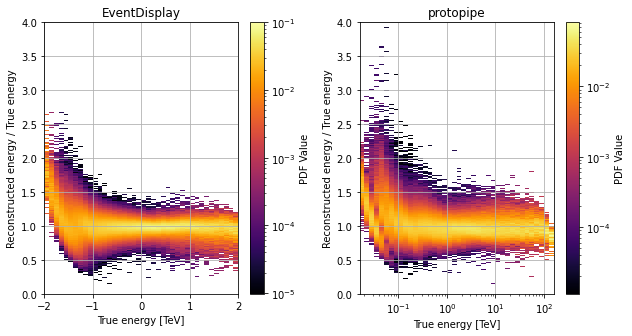

In [62]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)

plt.title("EventDisplay")
ED_migra, X, Y = ED_performance["EestOverEtrue"].to_numpy()
# make PDF
ED_migra = ED_migra/np.sum(ED_migra, axis=1)[np.newaxis].T

plt.pcolormesh(X, 
               Y, 
               ED_migra.T,
               cmap='inferno',
               norm=LogNorm())
plt.grid()
plt.colorbar(label='PDF Value')

plt.xlabel("True energy [TeV]")
plt.ylabel("Reconstructed energy / True energy")
plt.xlim(-2,2)
plt.ylim(0,4)

plt.subplot(1,2,2)

edisp = QTable.read(protopipe_file, hdu='ENERGY_DISPERSION')[0]

e_bins = edisp['ENERG_LO'][1:]
migra_bins = edisp['MIGRA_LO'][1:]

plt.title("protopipe")
plt.pcolormesh(e_bins.to_value(u.TeV), 
               migra_bins, 
               edisp['MATRIX'].T[1:-1, 1:-1, 0].T,
               cmap='inferno',
               norm=LogNorm())

plt.xscale('log')
plt.ylim(0,4)
plt.grid()
plt.colorbar(label='PDF Value')

plt.xlabel("True energy [TeV]")
plt.ylabel("Reconstructed energy / True energy")

None # to remove clutter by mpl objects

In [ ]:
# protopipe
bias_resolution = QTable.read(protopipe_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]
plt.errorbar(
    0.5 * (bias_resolution['reco_energy_low'] + bias_resolution['reco_energy_high']).to_value(u.TeV),
    bias_resolution['resolution'],
    xerr=0.5 * (bias_resolution['reco_energy_high'] - bias_resolution['reco_energy_low']).to_value(u.TeV),
    ls='',
    label='protopipe',
    color='DarkOrange'
)
plt.xscale('log')


# ED
y, edges = ED_performance["ERes"].to_numpy()
yerr = ED_performance["ERes"].errors()
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=ED_label,
             color='DarkGreen'
            )

# MARS
y, edges = MARS_performance["ERes"].to_numpy()
yerr = MARS_performance["ERes"].errors()
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=MARS_label,
             color='DarkBlue'
            )

# Style settings
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Energy resolution")
plt.grid(which="both")
plt.legend(loc="best")
plt.title(production)

None # to remove clutter by mpl objects

#### Energy bias
[back to top](#Table-of-contents)

In [ ]:
# protopipe
bias_resolution = QTable.read(protopipe_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]
plt.errorbar(
    0.5 * (bias_resolution['reco_energy_low'] + bias_resolution['reco_energy_high']).to_value(u.TeV),
    bias_resolution['bias']+1,  # not sure ...
    xerr=0.5 * (bias_resolution['reco_energy_high'] - bias_resolution['reco_energy_low']).to_value(u.TeV),
    ls='',
    label='protopipe',
    color='DarkOrange'
)
plt.xscale('log')


# ED
y, edges = ED_performance["Ebias"].to_numpy()
yerr = ED_performance["Ebias"].errors()
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=ED_label,
             color='DarkGreen'
            )

# Style settings
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Energy bias")
plt.grid(which="both")
plt.legend(loc="best")
plt.title(production)

None # to remove clutter by mpl objects

### Background rate
[back to top](#Table-of-contents)

In [ ]:
from pyirf.utils import cone_solid_angle

# protopipe
bg_rate = QTable.read(protopipe_file, hdu='BACKGROUND')[0]

reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

# first fov bin, [0, 1] deg
fov_bin = 0
rate_bin = bg_rate['BKG'].T[:, fov_bin]

# interpolate theta cut for given e reco bin
e_center_bg = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI'])
e_center_theta = 0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])
theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])

# undo normalization
rate_bin *= cone_solid_angle(theta_cut)
rate_bin *= np.diff(reco_bins)
plt.errorbar(
    0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1],
    rate_bin.to_value(1 / u.s)[1:-1],
    xerr=np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2,
    ls='',
    label='protopipe',
    color='DarkOrange'
)

# ED
y, edges = ED_performance["BGRate"].to_numpy()
yerr = ED_performance["BGRate"].errors()
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=ED_label,
             color="DarkGreen")


# MARS
y, edges = MARS_performance["BGRate"].to_numpy()
yerr = MARS_performance["BGRate"].errors()
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=MARS_label,
             color="DarkBlue")


# Style settings
plt.xscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Background rate / (s⁻¹ TeV⁻¹) ")
plt.grid(which="both")
plt.legend(loc="best")
plt.title(production)
plt.yscale('log')

None # to remove clutter by mpl objects